# 다양한 모델을 결합한 앙상블 학습

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,pandas,matplotib,scipy,sklearn

last updated: 2019-08-17 

CPython 3.7.3
IPython 7.6.1

numpy 1.16.4
pandas 0.24.2
matplotib not installed
scipy 1.2.1
sklearn 0.21.2


## 앙상블 학습
앙상블 학습은 여러개의 분류기를 하나의 메타 분류기로 연결하여 하나의 분류기보다 좋은 일반하 성능을 달성하는 것이다.  
과반수 투표법과 다수결 투표법이 있다.  
다양한 클래스를 사용할 때에는 다수결 투표를 사용하는 것이 좋다.


### 앙상블 학습이 개별 분류기보다 좋은 이유
개별 분류기를 사용하게 되면 에러율이 높은 반면,  
앙상블 학습이 실패하려면 반 이상의 분류기가 실패해야 하므로 에러율이 낮아지게 된다.  
> 앙상블 학습의 오차 확률은 이항 분포의 확률 질량 함수로 표현할 수 있다.

In [2]:
from scipy.special import comb # nCx 구해주는 함수
import math

def ensemble_error(n_classifier, error):
    """
    앙상블 학습 모델의 에러율을 구하는 함수
    
    Parameters
    ----------
    n_classifier : int, 분류기의 개수
    error: float, 에러율
    """
    
    # k의 시작 위치를 계산
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
            for k in range(k_start, n_classifier+1)]
    
    return sum(probs)

In [3]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

확률 질량 함수는 scipy의 binom.cdf()함수를 이용하여 쉽게 구할 수 있다.

In [9]:
from scipy.stats import binom

binom.cdf(5,11,0.75)

0.03432750701904298

에러가 0.0 ~ 1.0일 때 앙상블의 에러율과 개별 분류기의 에러를 시각화해보자.

In [4]:
import numpy as np

# 0.0 ~ 1.0사이에 0.01간격으로 값이 들은 array 생성
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
             for error in error_range]

In [5]:
import matplotlib.pyplot as plt

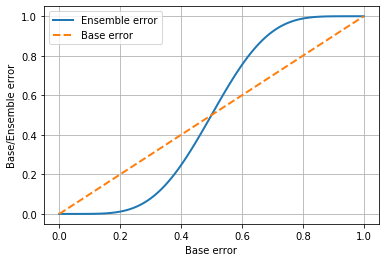

In [7]:
# 앙상블 에러율
plt.plot(error_range,
        ens_errors,
        label='Ensemble error',
        linewidth=2)

# 개별 분류기 에러율
plt.plot(error_range,
        error_range,
        label='Base error',
        linestyle='--',
        linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.show()

error율이 무작위 추측(0.5)보다 성능이 좋을 때 앙상블 학습이 에러율이 확실히 낮다.

### 다수결 투표를 사용한 분류 앙상블

가중치가 더해진 다수결 투표

In [12]:
import numpy as np
# argmax -> 최대값이 있는 곳의 index 반환
# bincount -> []리스트 안에 있는 값들의 빈도를 그 값의 인덱스 위치에 넣어서 반환
# weights가 주어지게 되면 count대신 그 웨이트 값들의 합을 반환
np.argmax(np.bincount([0,0,1],
                      weights=[0.2,0.2,0.6]))

1

앙상블 분류기가 잘 calibration 되어있다면 클래스 레이블 대신 예측 클래스 확률을 사용하는 것이 좋다.

In [14]:
ex = np.array([[0.9, 0.1],
              [0.8, 0.2],
              [0.4, 0.6]])

p = np.average(ex, axis=0,
              weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [15]:
np.argmax(p)

0

위의 것들을 모두 결합하여 MajorityVoteClassifier 파이썬 클래스를 구현해보자.

In [16]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

C:\Anaconda\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [29]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """
    다수결 투표 앙상블 분류기
    
    Parameters
    ----------
    classifiers: 배열 타입, 크기 =[n_classifiers]
        앙상블에 사용할 분류기
        
    vote: str, {'classlabel', 'probability'}
        기본값:'classlabel'
        'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 됩니다.
        'probability'이면 확률 합이 가장 큰 인덱스로
        클래스 레이블을 예측합니다(보정된 분류기에 추천합니다)
        
    weights: 배열 타입, 크기=[n_classifiers]
        선택사항, 기본값:None
        'int' 또는 'float' 값의 리스트가 주어지면 분류기가 이 중요도로 가중치 됩니다.
        'weights=None'이면 동일하게 취급됩니다.
    """
    
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        
        self.classifiers = classifiers
        self.named_classifiers = {key:value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """
        분류기를 학습합니다.
        
        Parameters
        ----------
        X: {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            훈련 샘플 행렬
        
        y: 배열 타입
            크기 = [n_samples]
            타깃 클래스 레이블 벡터
            
        Return
        ----------
        self: 객체
        """
        
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote는 'probability' 또는 'classlabel'이어야 합니다"
                            "(vote = %r)이 입력 되었습니다"
                            % self.vote)
            
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('분류기의 개수와 가중치 개수는 동일해야 합니다.'
                            '%d개의 가중치와, %d개의 분류기가 입력되었습니다.'
                            % (len(self.weights), len(self.classifiers)))
        
        # predict 메서드에서 np.argmax 할 때 
        # 클래스의 레이블이 0부터 시작해야 하므로 LabelEncoder를 사용한다.
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        # 각각의 classifier에 대하여 학습
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    
    def predict(self, X):
        """
        X에 대한 클래스 레이블을 예측합니다.
        
        Parameters
        ----------
        X:{배열 타입, 희소 행렬},
            크기 = [n_sampels, n_features]
            샘플 데이터 행렬
            
        Return
        ----------
        maj_vote : 배열 타입, 크기 = [n_samples]
            예측된 클래스 레이블
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X)
                                     for clf in self.classifiers_]).T
            
            maj_vote = np.apply_along_axis(
                                        lambda x:
                                        np.argmax(np.bincount(x, weights=self.weights)),
                                        axis=1,
                                        arr = predictions)
            
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    
    def predict_proba(self, X):
        """
        X에 대한 클래스 확률을 예측합니다.
        
        Parameter
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            n_samples는 샘플의 개수이고, n_features는 특성의 개수입니다.
        
        Return
        ----------
        avg_proba : 배열 타입,
            크기 = [n_samples, n_classes]
            샘플마다 가중치가 적용된 클래스의 평균 확률
        """
        
        probas = np.asarray([clf.predict_proba(X)
                            for clf in self.classifiers_])
        
        avg_probas = np.average(probas, axis=0, weights=self.weights)
        return avg_probas
    
    
    def get_params(self, deep=True):
        """GridSearch를 위해서 분류기의 매개 변수 이름을 반환합니다."""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
                    
            return out

In [30]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
# iris-versicolor와 iris-virginica 클래스에 해당하는 샘플 분류
# 꽃받침 너비와 꽃잎 길이 두개의 특성만 사용 
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = \
                train_test_split(X,y,
                                test_size=0.5,
                                random_state=1,
                                stratify=y)

앙상블 학습을 하기 전 개별 모델에 대하여 성능을 체크해보자.

In [31]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [32]:
clf1 = LogisticRegression(solver='liblinear',
                         penalty='l2',
                         C=0.001,
                         random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                             criterion='entropy',
                             random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                           p=2,
                           metric='minkowski')

pipe1 = Pipeline([('sc', StandardScaler()),
                 ('clf', clf1)])
pipe3 = Pipeline([('sc', StandardScaler()),
                 ('clf', clf3)])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-겹 교차 검증: \n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc')
    print("ROC AUC : %0.2f (+/- %0.2f) [%s]"
         %(scores.mean(), scores.std(), label))

10-겹 교차 검증: 

ROC AUC : 0.87 (+/- 0.17) [Logistic regression]
ROC AUC : 0.89 (+/- 0.16) [Decision tree]
ROC AUC : 0.88 (+/- 0.15) [KNN]


다수결 투표 포함하여 성능을 비교해보자

In [33]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

print('10-겹 교차 검증: \n')
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc')
    print("ROC AUC : %0.2f (+/- %0.2f) [%s]"
         %(scores.mean(), scores.std(), label))

10-겹 교차 검증: 

ROC AUC : 0.87 (+/- 0.17) [Logistic regression]
ROC AUC : 0.89 (+/- 0.16) [Decision tree]
ROC AUC : 0.88 (+/- 0.15) [KNN]
ROC AUC : 0.94 (+/- 0.13) [Majority voting]


In [34]:
from sklearn.metrics import roc_curve, auc

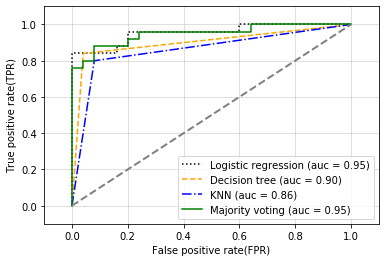

In [38]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls\
            in zip(all_clf, clf_labels, colors, linestyles):
    
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
    fpr , tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
            color=clr,
            linestyle=ls,
            label = '%s (auc = %0.2f)' %(label, roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0,1], [0,1],
        linestyle='--',
        color='gray',
        linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate(FPR)')
plt.ylabel('True positive rate(TPR)')

plt.show()

In [44]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

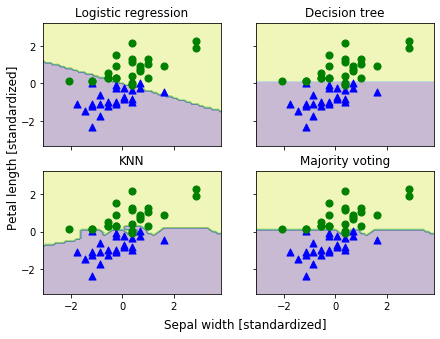

In [48]:
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col',
                        sharey='row',
                        figsize=(7,5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                       all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0],
                                 X_train_std[y_train == 0, 1],
                                 c='blue',
                                 marker = '^',
                                 s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                 X_train_std[y_train==1, 1],
                                 c='green',
                                 marker='o',
                                 s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)
    
plt.text(-3.5, -5.,
        s='Sepal width [standardized]',
        ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
        s='Petal length [standardized]',
        ha='center', va='center',
        fontsize=12, rotation=90)

plt.show()


GridSearchCV에서 어떻게 parameter에 접근할지 알아보기 위해 get_params()로 파라미터들을 확인해본다

In [49]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
          steps=[('sc',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('clf',
                  LogisticRegression(C=0.001, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='warn', n_jobs=None,
                                     penalty='l2', random_state=1,
                                     solver='liblinear', tol=0.0001, verbose=0,
                                     warm_start=False))],
          verbose=False),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
       

In [50]:
from sklearn.model_selection import GridSearchCV

In [52]:
params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc',
                    iid=False)
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

0.944 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.956 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.978 +/- 0.03 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.956 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.956 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.978 +/- 0.03 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


최적의 파라미터와 그 때의 정확도 확인

In [53]:
print('최적의 매개변수 : %s' % grid.best_params_)
print('정확도 : %.2f' % grid.best_score_)

최적의 매개변수 : {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
정확도 : 0.98


In [55]:
grid.best_estimator_.classifiers

[Pipeline(memory=None,
          steps=[('sc',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('clf',
                  LogisticRegression(C=100.0, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='warn', n_jobs=None,
                                     penalty='l2', random_state=1,
                                     solver='liblinear', tol=0.0001, verbose=0,
                                     warm_start=False))],
          verbose=False),
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_lea

In [56]:
mv_clf = grid.best_estimator_

In [58]:
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
                                             steps=[('sc',
                                                     StandardScaler(copy=True,
                                                                    with_mean=True,
                                                                    with_std=True)),
                                                    ('clf',
                                                     LogisticRegression(C=100.0,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                               

In [59]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
                                             steps=[('sc',
                                                     StandardScaler(copy=True,
                                                                    with_mean=True,
                                                                    with_std=True)),
                                                    ('clf',
                                                     LogisticRegression(C=100.0,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                               

## 배깅 : 부트스트랩 샘플링을 통한 분류 앙상블
배깅은 중복을 허락하여 부트스트랩을 랜덤 샘플링해서 학습을 시킨다.  
실제로 더 고차원 데이터셋을 이용할 경우 단일 결정 트리는 쉽게 과대 적합된다.  
이런 경우에 배깅 알고리즘이 적합하다.  
배깅은 모델의 분산을 감소시키는 적절한 방법이지만 편향을 해결하기는 어렵다.

### 배깅으로 Wine 데이터셋의 샘플 분류하기

In [61]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [62]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = \
        train_test_split(X, y,
                        test_size=0.2,
                        random_state=1,
                        stratify=y)

In [63]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                             max_depth=None,
                             random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                       n_estimators=500,
                       max_samples=1.0,
                       max_features=1.0,
                       bootstrap=True,
                       bootstrap_features=False,
                       n_jobs=1,
                       random_state=1)

DecisionTree와 Bagging의 성능 비교

In [64]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
     %(tree_train, tree_test))

결정 트리의 훈련 정확도/테스트 정확도 1.000/0.833


In [65]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f'
     %(bag_train, bag_test))

배깅의 훈련 정확도/테스트 정확도 1.000/0.917


결정트리와 배깅의 결정 경계를 비교해보자.

In [66]:
import numpy as np
import matplotlib.pyplot as plt

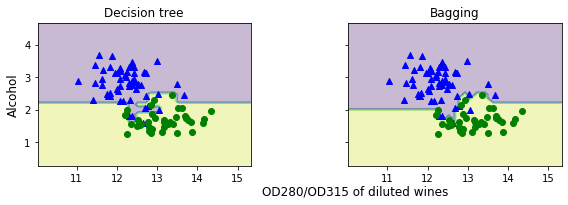

In [67]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                       sharex='col',
                       sharey='row',
                       figsize=(8,3))


for idx, clf, tt in zip([0, 1],
                       [tree, bag],
                       ['Decision tree', 'Bagging']):
    
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                      X_train[y_train == 0, 1],
                      c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                      X_train[y_train == 1, 1],
                      c='green', marker='o')
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5,
        s='OD280/OD315 of diluted wines',
        ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

## 약한 학습기를 이용한 에이다부스트
부스트는 중복을 허락하지 않고 샘플링을 하여 약한 학습기에 학습을 시키고 제대로 분류해내지 못한 샘플을 다음 학습기의 샘플로 넣는 방식이다.

### 사이킷런에서 에이다부스트 사용하기

In [68]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                             max_depth=1,
                             random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                        n_estimators=500,
                        learning_rate=0.1,
                        random_state=1)

In [70]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
     %(tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('에이다부스트의 훈련 정확도/테스트 정확도 %.3f/%.3f'
     %(ada_train, ada_test))

결정 트리의 훈련 정확도/테스트 정확도 0.916/0.875
에이다부스트의 훈련 정확도/테스트 정확도 1.000/0.917


에이다부스트를 사용했을 때의 결정 경계를 그려보자

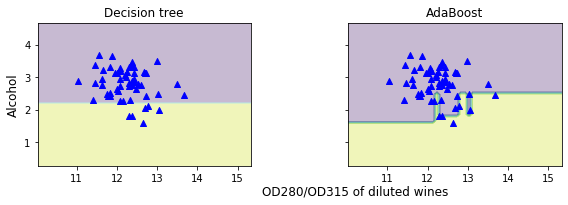

In [71]:
x_min, x_max = X_train[:,0].min() - 1, X_train[:,0].max() + 1
y_min, y_max = X_train[:,1].min() - 1, X_train[:,1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

# subplots(nrows, ncols, sharex, sharey) -> fig, ax(Axes : array)
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8,3))


for idx, clf, tt in zip([0,1],
                       [tree, ada],
                       ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    
    # np.c_ : column stack 옆으로 붙여준다.
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                      X_train[y_train==0, 1],
                      c='blue', marker='^')
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5,
        s='OD280/OD315 of diluted wines',
        ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

#### GradientBoostingClassifier
- 배깅이랑 유사하게 나타난다

In [72]:
from sklearn.ensemble import GradientBoostingClassifier

In [73]:
gbrt = GradientBoostingClassifier(n_estimators=20, random_state=42)

gbrt.fit(X_train, y_train)
gbrt_train_score = gbrt.score(X_train, y_train)
gbrt_test_score = gbrt.score(X_test, y_test)

print('앙상블에 사용한 트리 개수 %d' % gbrt.n_estimators_)
print('그래디언트 부스팅 train/test 정확도 %.3f/%.3f'
     % (gbrt_train_score, gbrt_test_score))

앙상블에 사용한 트리 개수 20
그래디언트 부스팅 train/test 정확도 1.000/0.917


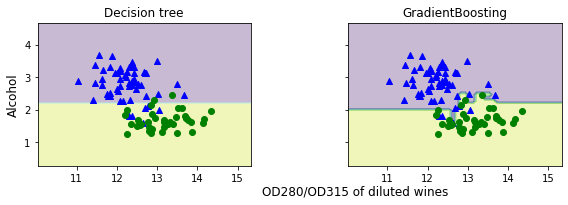

In [75]:
x_min, x_max = X_train[:,0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1,2, sharex='col', sharey='row', figsize=(8,3))


for idx, clf, tt in zip([0,1],
                       [tree,gbrt],
                       ['Decision tree', "GradientBoosting"]):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                      X_train[y_train==0, 1],
                      c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],
                      X_train[y_train==1, 1],
                      c='green', marker='o')
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5,
        s='OD280/OD315 of diluted wines',
        ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()